In [2]:
import numpy as np 

import jax
import jax.numpy as jnp 
from jax import lax
from jax.numpy import einsum


import matplotlib.pyplot as plt

import scipy
from scipy.special import legendre
from scipy.special import spherical_jn 

import sys
import os
from functools import partial


from kltpicker_3d.alt_least_squares import alternating_least_squares_solver
from kltpicker_3d.tests.exp_spectrum import *
from kltpicker_3d.tests.gaussian_spectrum import * 
from kltpicker_3d.tests.rpsd_test_data import generate_gaussian_rpsd_data
from kltpicker_3d.tomogram import factorize_RPSD
from kltpicker_3d.utils import * 


jax.config.update("jax_default_device", jax.devices("cpu")[0])

plt.rcParams.update({
    "axes.grid": True,
    "grid.alpha": 0.5
})

In [3]:
def generate_uniform_radial_sampling_points(L,r_max, nbins=None):
    # Frequency lattice in cycles/pixel
    k = np.fft.fftshift(np.fft.fftfreq(L, d=1.0/(2*r_max)))      
    kx, ky, kz = np.meshgrid(k, k, k, indexing='ij')
    r = np.sqrt(kx**2 + ky**2 + kz**2)  
    eps = np.finfo(float).eps

    mask = (r <= r_max)
    r_inside = r[mask]
    r_edge = r_inside.max()
    df = 2.0 * r_max / L
    # Number of bins
    if nbins is None:
        nbins = int(max(1, np.floor(r_edge / df)))

    # Uniform-in-radius edges & centers on [0, r_max]
    r_edges = np.linspace(0.0, r_edge, nbins + 1)
    uniform_points = 0.5 * (r_edges[:-1] + r_edges[1:])

    # Indices per shell (last bin inclusive on upper edge)
    bins = []
    for j in range(nbins):
        lo, hi = r_edges[j], r_edges[j+1]
        if j < nbins - 1:
            mask = (r >= lo) & (r < hi)
        else:
            mask = (r >= lo) & (r <= hi + eps)
        bins.append(np.where(mask))

    return uniform_points, bins

N = 32 
vect_spectrum_estimation = jax.vmap(estimate_isotropic_powerspectrum_tensor,
                                    in_axes=(0,None))
max_d = int(np.floor(N/3))   

In [4]:
K = 100
M = 2*N - 1 

c = 5
                                            
grid = np.fft.fftshift(np.fft.fftfreq(M, d=1.0/(2*c)))
i,j,k  = np.meshgrid(grid,grid,grid)
omega_r = np.sqrt(i**2 + j**2 + k**2)
mask = (omega_r <= c)

# Q: Why it works better for alpha*c for alpha > 1? It was constructed
# such that it should truncate at c 
T = -np.log(1e-16)/(5*c)
H = np.exp(-T*omega_r) * mask
C = M ** 3 / H.sum()
normalized_H = np.fft.ifftshift(np.sqrt(H * C))

samples = np.zeros((K,N,N,N))
alphas = np.random.beta(2,5,size=(K)) 
for k in range(K):
    noise = np.random.normal(size=(M,M,M))
    additive_noise = np.random.normal(scale=0.1,size=(M,M,M))
    sample = np.fft.ifftn(normalized_H*np.fft.fftn(noise))
    sample = alphas[k]*sample + additive_noise
    samples[k] = sample[:N,:N,:N]

samples = samples.real 

/tmp/ipykernel_2358713/4235270894.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  samples[k] = sample[:N,:N,:N]


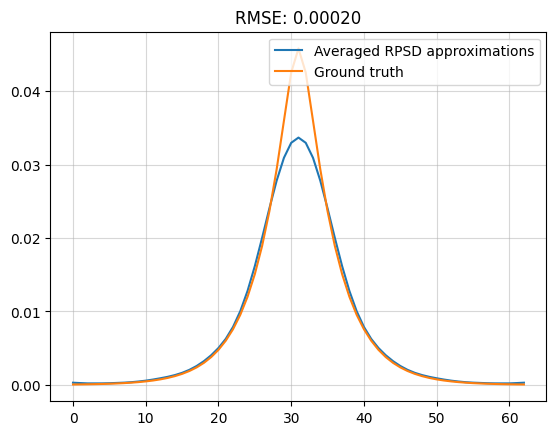

In [5]:
samples = samples - jnp.mean(samples, axis=(1,2,3)).reshape(-1,1,1,1)
psd = vect_spectrum_estimation(samples,max_d)  

S = H / np.linalg.norm(H)
avg_psd = np.mean(psd,axis=0)
avg_psd /= np.linalg.norm(avg_psd)

plt.plot(avg_psd[N,N,:], label='Averaged RPSD approximations')
plt.plot(S[N,N,:], label='Ground truth')
plt.title(f"RMSE: {np.sqrt(np.mean((avg_psd - S)**2)):.5f}")
plt.legend();

In [6]:
def trigonometric_interpolation(x,y,z):
    n = x.shape[0]
    
    scale = (x[1] - x[0]) * n / 2 
    x_scaled = (x / scale) * jnp.pi / 2 
    z_scaled = (z / scale) * jnp.pi / 2

    delta = z_scaled[:, None] - x_scaled[None, :]
    # We take n to be only even 
    M = jnp.sin(n*delta) / (n *jnp.sin(delta))
    #if n % 2 == 0:
    #    M = np.sin(n*delta) / (n *jnp.sin(delta))
    #else:
    #    M = np.sin(n*delta)/ (n*jnp.tan(delta))
    M = M.at[jnp.isclose(delta,0)].set(1.0)

    p = M @ y 
    return p

def radial_average1(X, bins, n):
    S = np.zeros(n)
    for j in range(n):
        bin_len = bins[j][0].size
        if bin_len != 0:    
            S[j] += np.mean(X[bins[j][0]])
    return S

In [7]:
uniform_points, bins = generate_uniform_radial_sampling_points(N,c)
rblocks = np.array([radial_average1(psd[k], bins, len(bins)) for k in range(K)])
factorization = alternating_least_squares_solver(rblocks,500,1e-4)

/tmp/ipykernel_2358713/3152558588.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1,0].legend()


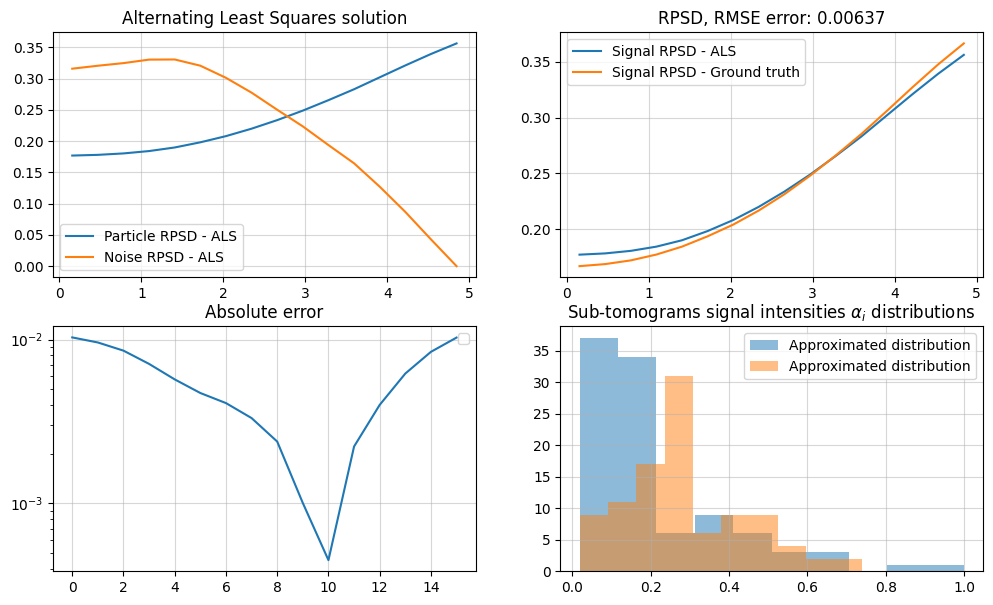

In [8]:
particle_psd = factorization.gamma
noise_psd = factorization.v

noise_psd /= np.linalg.norm(noise_psd)
particle_psd /= np.linalg.norm(particle_psd)


fig, ax = plt.subplots(2,2, figsize=(12,7))

extracted_alphas = factorization.alpha

H /= np.linalg.norm(H)

true_rpsd = radial_average1(H,bins, len(bins))
true_rpsd /= np.linalg.norm(true_rpsd)

ax[0,0].plot(uniform_points,particle_psd, label='Particle RPSD - ALS')
ax[0,0].plot(uniform_points,noise_psd, label='Noise RPSD - ALS')
ax[0,0].set_title("Alternating Least Squares solution")
ax[0,0].legend()


ax[0,1].plot(uniform_points,particle_psd,label='Signal RPSD - ALS')
ax[0,1].plot(uniform_points,true_rpsd, label='Signal RPSD - Ground truth')
#ax[0,1].set_yscale('log')
ax[0,1].set_title("RPSD benchmark")
ax[0,1].set_title(f"RPSD, RMSE error: {np.sqrt(np.mean((true_rpsd - particle_psd)**2)):.5f}")
ax[0,1].legend()

ax[1,0].set_title("Absolute error")
ax[1,0].plot(np.abs(true_rpsd - particle_psd))
ax[1,0].set_yscale('log')
ax[1,0].legend()

ax[1,1].set_title(r"Sub-tomograms signal intensities $ \alpha_i$ distributions")
ax[1,1].hist(extracted_alphas,alpha=0.5, label='Approximated distribution')
ax[1,1].hist(alphas,alpha=0.5, label='Approximated distribution')
ax[1,1].legend();

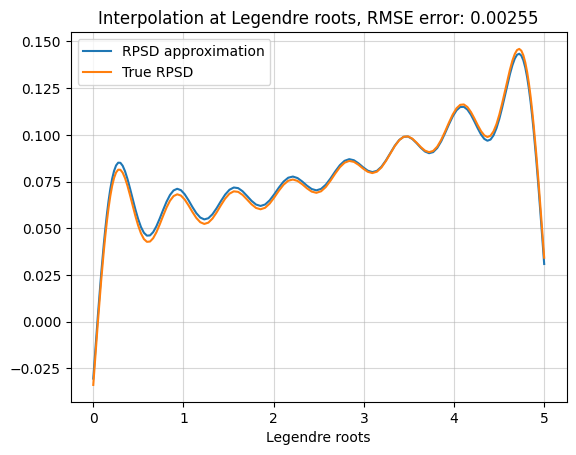

In [9]:
particle_psd = factorization.gamma
X,w = scipy.special.roots_legendre(150)
X_scaled = c/2*X + c/2
Gx = trigonometric_interpolation(uniform_points, particle_psd, X_scaled)
Gx /= np.linalg.norm(Gx)
Gx_true = trigonometric_interpolation(uniform_points, true_rpsd, X_scaled)
Gx_true /= np.linalg.norm(Gx_true)
plt.title("RPSD interpolation")
plt.plot(X_scaled, Gx, label='RPSD approximation')
plt.plot(X_scaled, Gx_true, label='True RPSD')
plt.title(f"Interpolation at Legendre roots, RMSE error: {np.sqrt(np.mean((Gx_true - Gx)**2)):.5f}")
plt.xlabel("Legendre roots")
plt.legend();

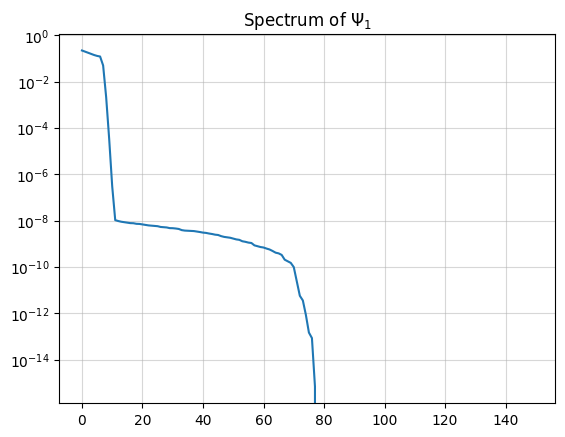

In [10]:
from kltpicker_3d.fredholm_solver import solve_radial_fredholm_equation


eigvals, eigfuncs,W = solve_radial_fredholm_equation(Gx,1,1,c)
plt.plot(eigvals)
plt.yscale('log')
plt.title(r"Spectrum of $\Psi_{1}$");

/tmp/ipykernel_2354138/3979562358.py:29: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax[i//3,i%3].pcolormesh(X, Y, R_2d, cmap='inferno', shading='auto')


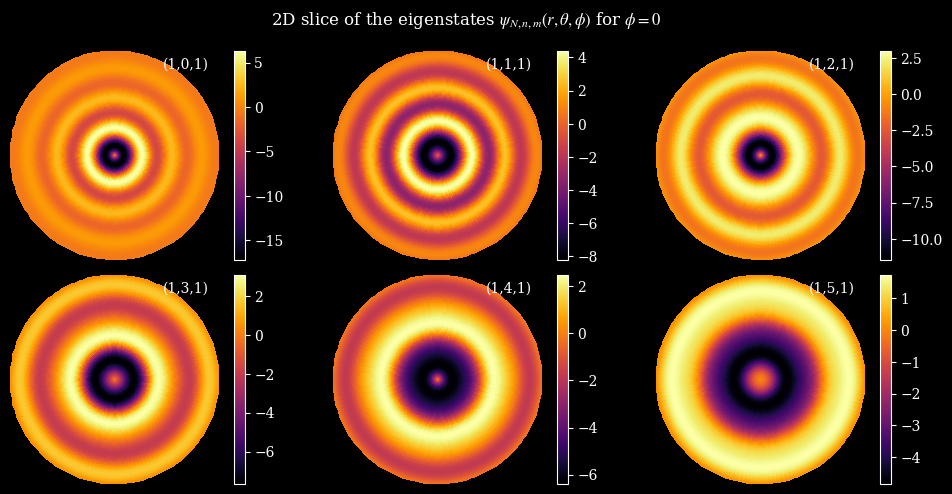

In [13]:
plt.style.use('dark_background')

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "STIX", "DejaVu Serif"],
    "mathtext.fontset": "stix",
    "text.color": "white"
})

fig,ax = plt.subplots(2,3,figsize=(10,5))

a = 1
k = 150
m = 1

rho,w = scipy.special.roots_legendre(k)
rho_a = a/2*rho + a/2

theta = np.linspace(0, 2*np.pi, k)
theta_g, r_g = np.meshgrid(theta, rho_a)
X = r_g * np.cos(m*theta_g)
Y = r_g * np.sin(m*theta_g)

for i in range(6):
    R = eigfuncs[:,i].real 
    R_2d = np.tile(R[:, np.newaxis], (1, k))

    r,c = divmod(i,3)
    im = ax[i//3,i%3].pcolormesh(X, Y, R_2d, cmap='inferno', shading='auto')
    ax[r,c].set_xlim(-a,a)
    ax[r,c].set_xlim(-a,a)
    ax[r,c].set_aspect('equal')
    #x[r,c].set_title(f'$\psi _{1,i,1}(r, \theta)$')
    ax[r,c].text(
        0.95,0.90,f"(1,{i},1)",
        transform=ax[r, c].transAxes,      # relative to the axes, not data
        color="white",
        fontsize=10,
        ha="right", va="bottom"
    )
    fig.colorbar(im, ax=ax[i//3, i%3])

for ax in ax.ravel():
    ax.set_axis_off()

fig.suptitle(r"2D slice of the eigenstates $\psi_{N,n,m}(r,\theta,\phi)$ for $\phi=0$")
plt.tight_layout();

In [14]:
plt.style.use('default')

In [11]:
def fredholm_solver(Gx,N,a,c,K=150):
    def Hn(x):
        return 2*np.pi * (2*(1j**N) * spherical_jn(N,x))

    X,w = scipy.special.roots_legendre(K)
    inner_rho = (c/2)*X + c/2
    outer_rho = (a/2)*X + a/2

    inner_grid = np.outer(inner_rho,inner_rho)
    vv = Hn(inner_grid)
    sgn = -1.0 if (N % 2) else 1.0
    D = (c/2) * w * Gx * (inner_rho**2)
    H = (vv * D[None,:]) @ (sgn *vv).T
    W = a/2 * np.diag(w*(outer_rho)**2)
    
    # Make H symmetric for stable solution
    A = np.sqrt(W) @ H @ np.sqrt(W)    
    eigvals, Y = np.linalg.eigh(A)
    R = np.linalg.solve(np.sqrt(W), Y) 

    eigvals = eigvals[::-1]
    eigfuncs = R[:,::-1]

    eigvals = np.where(np.abs(eigvals) < np.spacing(1),0, eigvals)
    eigfuncs[:,eigvals ==0] = 0
    return eigvals, eigfuncs, W

eigvals, eigfuncs,W = fredholm_solver(Gx,0,1,c)

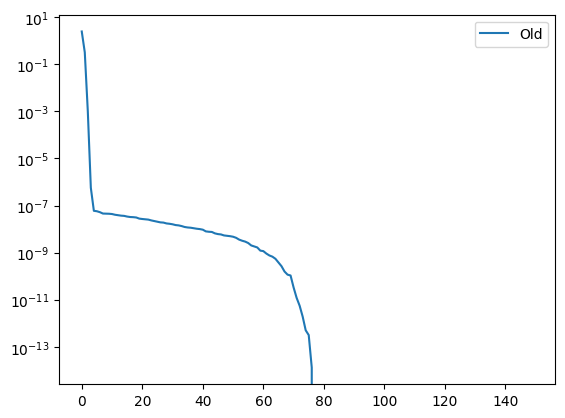

In [16]:
plt.plot(eigvals,label='Old')
plt.yscale('log')
plt.legend();

In [12]:
max_order = 100 
eigvals, eigfuncs = [],[]
for i in range(max_order):
    lambdas, funcs,W = fredholm_solver(Gx,i,1,c)
    eigvals.append(lambdas)
    eigfuncs.append(funcs)

eigfuncs = np.array(eigfuncs).reshape(-1,150)
eigvals = np.array(eigvals).reshape(-1)

orders = np.tile(np.arange(max_order).reshape(-1, 1), (1, 150)).reshape(-1)

idx = np.argsort(eigvals)[::-1]
orders = orders[idx]

eigfuncs = eigfuncs[idx,:]
eigvals = eigvals[idx]

idx = np.where(eigvals > np.spacing(1))[0]
eigvals = eigvals[idx]
eigfuncs = eigfuncs[idx,:]
orders = orders[idx]

Note that the radial solutions are sampled at Legendre roots which are good for integration but as as interpolation nodes. Hence we re-arrange the KLT equation into the form:

$$ R(r) = \frac{1}{\lambda} \int_{0}^{a} \Psi_N(r,r') R(r')r'^{2} dr $$

Note that to approximate the integral we already have $R$ sampled at Legendre nodes so we can approximate this efficiently.

In [15]:
from scipy.special import spherical_jn

N = 32
a = 1
grid = np.arange(-(N-1),N)
X,Y,Z = np.meshgrid(grid,grid,grid)
r_tensor = np.sqrt(X**2 + Y**2 + Z**2)
rho_uniform, idx = np.unique(r_tensor,return_inverse=True)

rho_leg, w = scipy.special.roots_legendre(150)
rho_leg_a =  (a / 2.0) * rho_leg + a / 2.0  
rho_leg_c =  c / 2 * rho_leg + c / 2

# Truncates the spectra to contain 99% of the data
eigval_cumsum = np.cumsum(eigvals / np.sum(eigvals))
truncate_idx = (eigval_cumsum > 0.99).argmax() + 1

eigfuncs = eigfuncs[:truncate_idx,...]
eigvals = eigvals[:truncate_idx]
orders = orders[:truncate_idx,...]

r_grid_uni = np.outer(rho_uniform, rho_leg_c)
r_grid_leg = np.outer(rho_leg_a, rho_leg_c)

def Hn_scipy(x,N):
    return 4*np.pi * ((1j**N) * spherical_jn(N,x))

# Hn evaluated at multiples of uniform radial points
Hn_uniform = np.array(
    [Hn_scipy(r_grid_uni,N) for N in range(orders.max()+1)]
)

# Hn evaluated at multiples Legendre roots 
Hn_leg = np.array(
    [Hn_scipy(r_grid_leg,N) for N in range(orders.max()+1)]
)

Hn_leg = Hn_leg[orders]
Hn_uniform = Hn_uniform[orders]

sgn = np.where(orders % 2 == 1, -1, 1)
D = (c/2) * w * Gx * (rho_leg_c**2)
W = a * 0.5 * w* rho_leg_a**2


#H_right = np.swapaxes(sgn[:,None,None]* Hn_leg, -1,-2)
H_right = sgn[:,None,None]* Hn_leg
psi = (Hn_uniform * D[None,None,:]) @ H_right
eigfuncs_uniform = np.einsum('bik,k,bk->bi', psi,W,eigfuncs) / eigvals[:,None]
radial_templates = eigfuncs_uniform[:,idx]

In [16]:
theta = np.arctan2(Y, X)
phi = np.arctan2(Z,np.sqrt(X**2 + Y**2))


N_max = orders.max()+1
sph_harm = np.zeros((N_max,N_max) + theta.shape, dtype=np.complex64)
for N in range(N_max):
    for m in range(N):
        sph_harm[N,m] = scipy.special.sph_harm(m,N,theta,phi)

templates = sph_harm[orders]*radial_templates[:,None,...]

In [17]:
eigvals_r = np.repeat(eigvals[None,:],4,axis=0).flatten()
P = templates.reshape((truncate_idx * N_max),-1).T

In [ ]:
q,r = np.linalg.qr(P)
